In [2]:
from automltsad.utils import (
    Autoperiod,
    sliding_window_sequences,
    to_time_series_dataset,
    reduce_window_scores
)
from automltsad.detectors import LOF, KNN, IsolationForestAD
from automltsad.metrics import precision_recall_curve, f1_pa
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
from multiprocessing import Pool
warnings.filterwarnings('ignore')

In [3]:
with open('data/train.txt') as f:
    datasets = f.readlines()

In [4]:
# print(np.random.choice(list(range(len(datasets))), 10, False))
dataset_idx = [18, 137,  71,  85,  35, 126,  20,  75,   6,  43]
dataset_names = [datasets[i].strip('\n') for i in dataset_idx]
print(dataset_names)

['196_UCR_Anomaly_sel840mECG2_20000_49370_49740.txt', '022_UCR_Anomaly_DISTORTEDGP711MarkerLFM5z4_4000_6527_6645.txt', '091_UCR_Anomaly_DISTORTEDtiltAPB3_40000_114000_114370.txt', '227_UCR_Anomaly_mit14134longtermecg_11231_29000_29100.txt', '149_UCR_Anomaly_Lab2Cmac011215EPG5_7000_17390_17520.txt', '054_UCR_Anomaly_DISTORTEDWalkingAceleration5_2700_5920_5979.txt', '151_UCR_Anomaly_MesoplodonDensirostris_10000_19280_19440.txt', '104_UCR_Anomaly_NOISEapneaecg4_6000_16000_16100.txt', '030_UCR_Anomaly_DISTORTEDInternalBleeding19_3000_4187_4197.txt', '168_UCR_Anomaly_gait2_22000_46500_46800.txt']


In [5]:
# for i, n in enumerate(dataset_names):
def load_dataset(filename):
    test_start, anomaly_start, anomaly_end = [
        int(i) for i in filename.split('.')[0].split('_')[-3:]
    ]
    ts = np.loadtxt(f'./data/datasets/{filename}')
    ts = to_time_series_dataset(ts)
    train = ts[:,:test_start]
    test = ts[:,test_start:]
    label = np.zeros_like(test)
    label[:,anomaly_start-test_start:anomaly_end-test_start] = 1
    label = np.squeeze(label)
    return train, test, label, test_start, anomaly_start, anomaly_end

def window_data(train, test, size):
    train_w = sliding_window_sequences(train, size)
    test_w = sliding_window_sequences(test, size)
    return train_w, test_w

id_to_detector = dict(
    knn=KNN,
    lof=LOF,
    isoforest=IsolationForestAD
)

hyperparams = {
    'knn':{
        'n_neighbors':15
    },
    'lof':{}, # Default
    'isoforest':{} # Default
}

In [6]:
detectors = ['knn', 'lof', 'isoforest']
window_sizes = list(range(8,513,8))
f1_scores = np.zeros((len(detectors), len(dataset_names), len(window_sizes)))
f1_wo_pa_scores = np.zeros((len(detectors), len(dataset_names), len(window_sizes)))
f1_pa_scores = np.zeros((len(detectors), len(dataset_names), len(window_sizes)))

configurations = []
for i, det_id in enumerate(detectors):
    for j, fn in enumerate(dataset_names):
        for k, sz in enumerate(window_sizes): # Window sizes
            configurations.append((i,j,k,det_id,fn,sz))

def process_task(config):
    i, j, k, det_id, fn, sz = config
    train, test, label, test_start, anomaly_start, anomaly_end = load_dataset(fn)
    train_w, test_w = window_data(train, test, sz)
    detector = id_to_detector[det_id]
    model = detector(**hyperparams[det_id])
    model.fit(train_w)
    scores = model.predict_anomaly_scores(test_w)
    scores = reduce_window_scores(scores, sz)
    p, r, t = precision_recall_curve(label, scores)
    f1 = 2*p*r / (p+r+1e-12)
    idx = np.nanargmax(f1)
    step = max(len(t)//100,1)
    f1_pas = [f1_pa(label, scores, th) for th in t[::step]]
    f1pat = f1_pa(label, scores, t[idx])
    f1pa = np.max(f1_pas)
    return i, j, k, f1[idx], f1pat, f1pa



'''
No need to rerun
'''
# for c in configurations:
#     i,j,k,f1,f1pat,f1pa = process_task(c)
#     f1_scores[i, j, k]=f1
#     f1_wo_pa_scores[i, j, k]=f1pat
#     f1_pa_scores[i, j, k]=f1pa
# np.savez('./results/window_size_experiment_results', f1_scores=f1_scores, f1_wo_pa_scores=f1_wo_pa_scores, f1_pa_scores=f1_pa_scores)

# window_ap = np.zeros(len(dataset_names))
# for j, fn in enumerate(tqdm(dataset_names)):
#     train, _, _, _, _, _ = load_dataset(fn)
#     window_ap[j] = Autoperiod(np.squeeze(train)).period
# np.save('./results/window_size_experiment_autoperiod', window_ap)

In [10]:
# Read results from previous cell
data = np.load('./results/window_size_experiment_results.npz')
dataset_period = np.load('./results/window_size_experiment_autoperiod.npy')
f1_s, f1_wo_pa, f1_pa = data['f1_scores'], data['f1_wo_pa_scores'], data['f1_pa_scores']

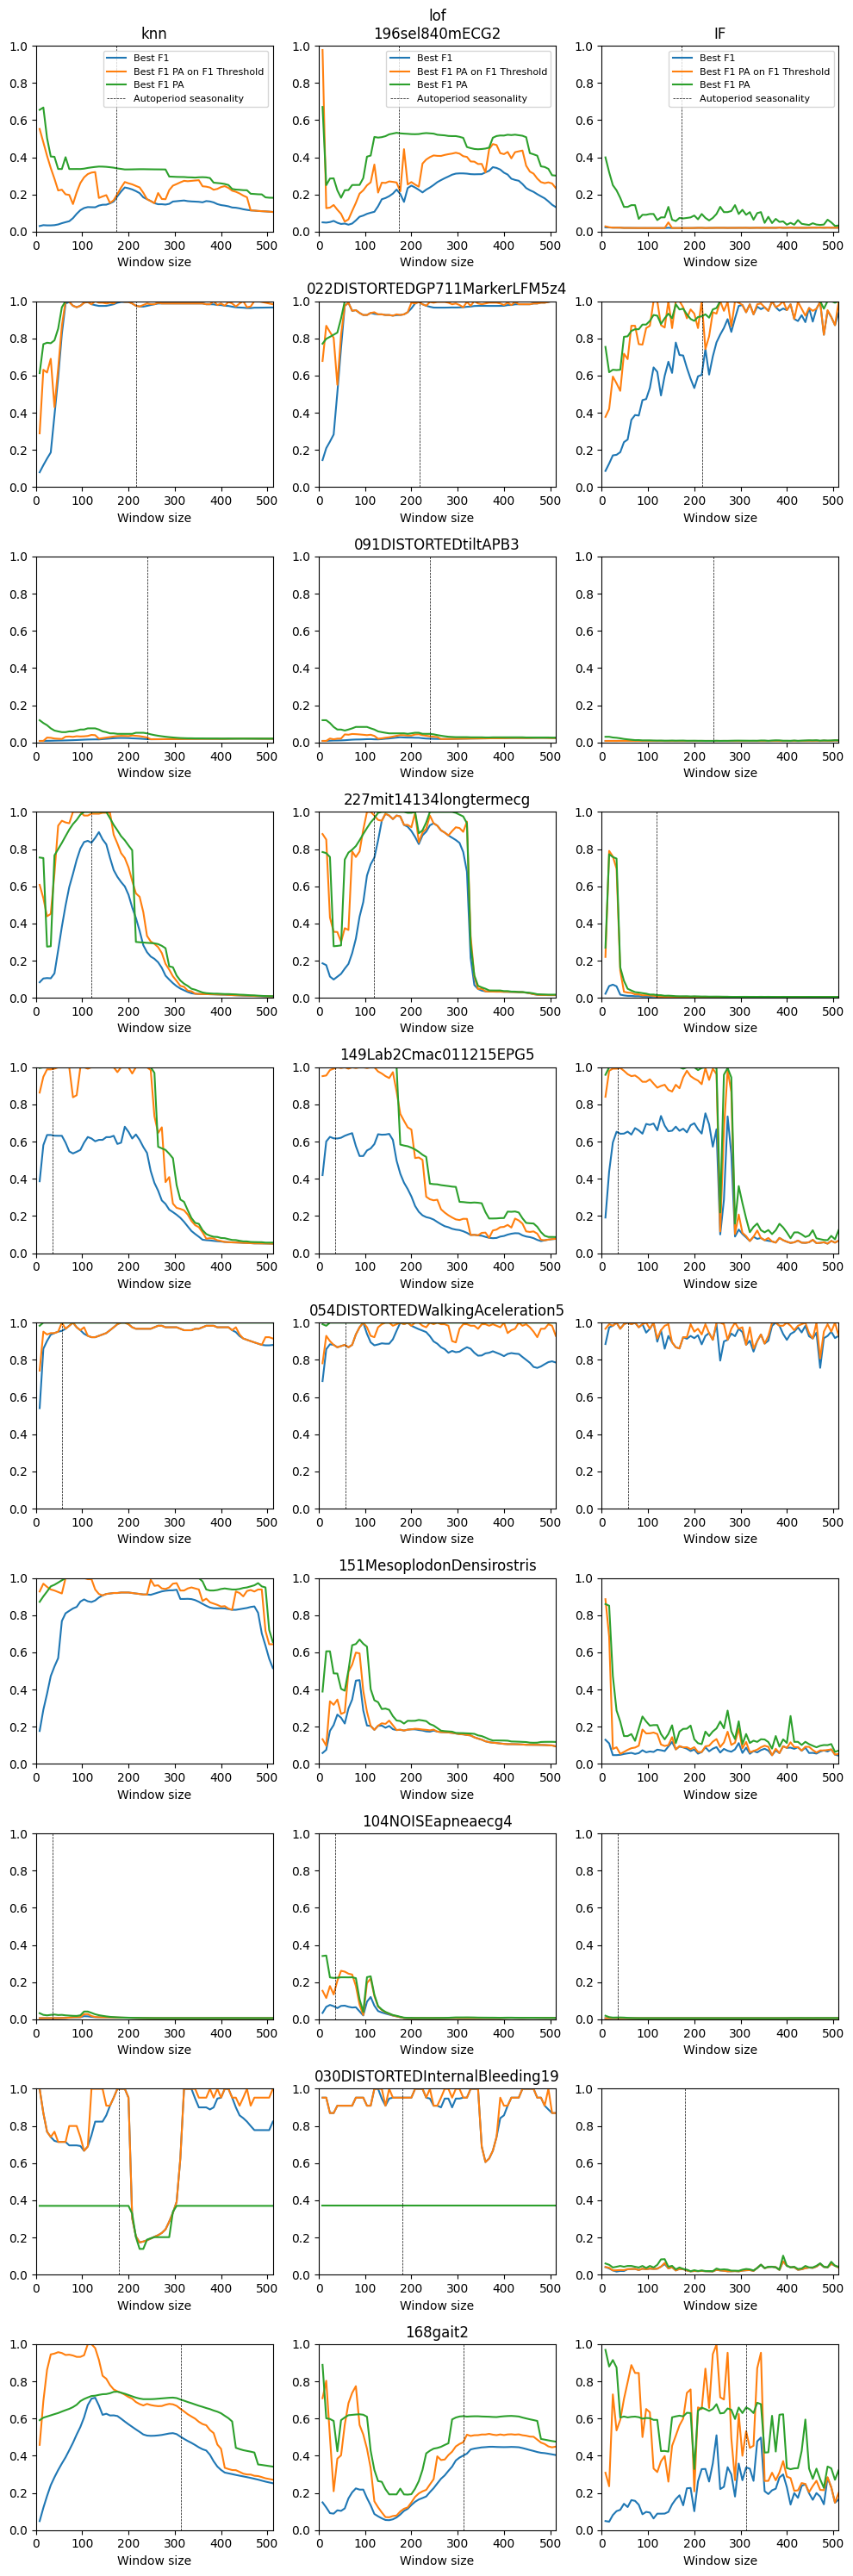

In [55]:
plt.figure(figsize=(10,30), dpi=100)
for i, det in enumerate(detectors):
    for j, fn in enumerate(dataset_names):
        fn = fn.split('_')[0] + fn.split('_')[3]
        plt.subplot2grid((10, 3), (j, i))
        plt.plot(window_sizes, f1_s[i, j], label='Best F1')
        plt.plot(window_sizes, f1_wo_pa[i, j], label='Best F1 PA on F1 Threshold')
        plt.plot(window_sizes, f1_pa[i, j], label='Best F1 PA')
        plt.axvline(dataset_period[j], ls='--', lw=0.5, color='black', label='Autoperiod seasonality')
        plt.xlabel('Window size')
        plt.ylim(0,1)
        plt.xlim(0,512)
        if j == 0:
            plt.legend(fontsize=8)
            if i == 1:
                plt.title(f'{det}\n{fn}', fontsize=12)
            else:
                plt.title(f'{det}', fontsize=12)
            
        elif i == 1:
            plt.title(f'{fn}', fontsize=12)
    plt.tight_layout()


In [63]:
import multiprocessing
import pandas as pd
import tqdm

with open('data/train.txt') as f:
    train = f.readlines()

with open('data/test.txt') as f:
    test = f.readlines()

files = train + test

def task(file):    
    start, a_start, a_end = [
        int(i) for i in file.split('.')[0].split('_')[-3:]
    ]
    file = file.strip('\n')
    ts = np.loadtxt(f'./data/datasets/{file}')
    traints = ts[:start]
    train_period = Autoperiod(traints).period
    period = Autoperiod(ts).period
    return file, train_period, period


periods = []

with multiprocessing.Pool(processes=10) as pool:
    results = list(tqdm.tqdm(pool.imap(task, files), total=len(files)))

with open('./data/period.txt','w') as f:
    for r in results:
        f.write(f'{r[0]}, {r[1]}, {r[2]}\n')

100%|██████████| 208/208 [32:22<00:00,  9.34s/it]  
